# 模型保存与载入
- 对于**训练调优场景**，我们推荐使用paddle.save/load保存和载入模型；
- 对于**推理部署场景**，我们推荐使用paddle.jit.save/load（动态图）和paddle.static.save/load_inference_model（静态图）保存载入模型。
    - [paddle.save](https://www.paddlepaddle.org.cn/documentation/docs/zh/api/paddle/save_cn.html#cn-api-paddle-framework-io-save)
    - [paddle.load](https://www.paddlepaddle.org.cn/documentation/docs/zh/api/paddle/load_cn.html#cn-api-paddle-framework-io-load)
    - [paddle.jit.save](https://www.paddlepaddle.org.cn/documentation/docs/zh/api/paddle/jit/save_cn.html#cn-api-paddle-jit-save)
    - [paddle.jit.load](https://www.paddlepaddle.org.cn/documentation/docs/zh/api/paddle/jit/save_cn.html#cn-api-paddle-jit-save)
    - [paddle.static.save_inference_model](https://www.paddlepaddle.org.cn/documentation/docs/zh/api/paddle/static/save_inference_model_cn.html#cn-api-static-save-inference-model)
    - [paddle.static.load_inference_model](https://www.paddlepaddle.org.cn/documentation/docs/zh/api/paddle/static/load_inference_model_cn.html#cn-api-fluid-io-load-inference-model)
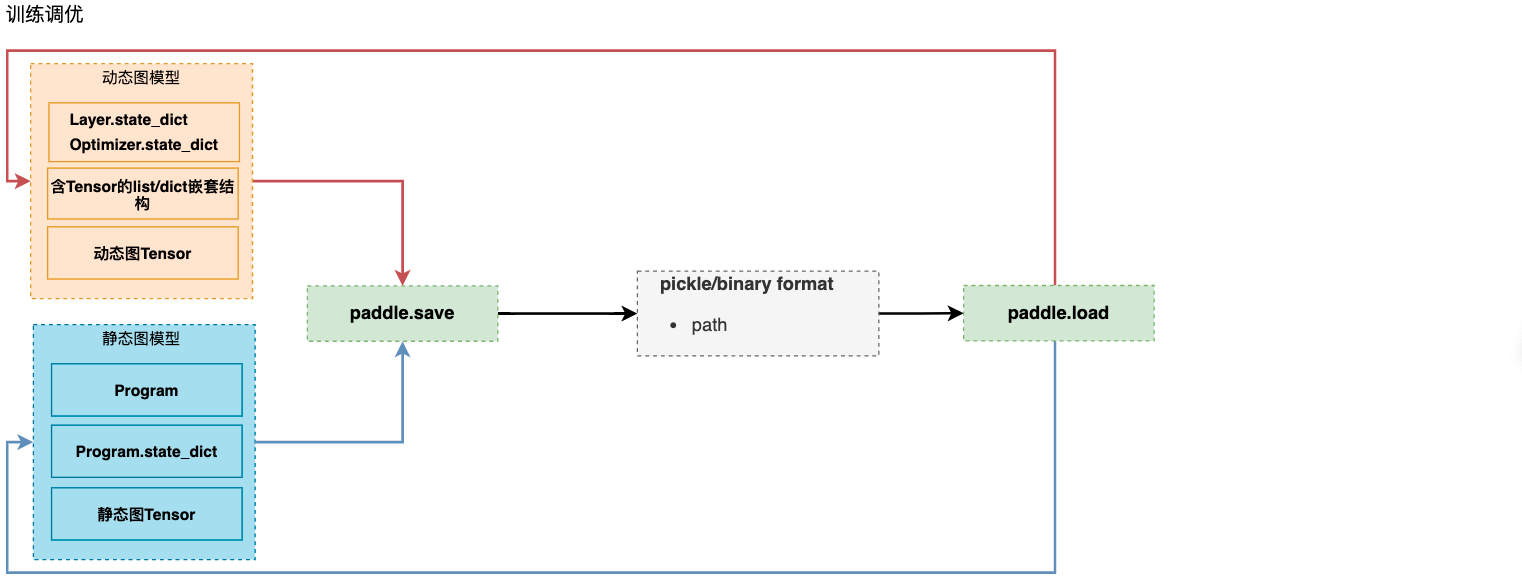
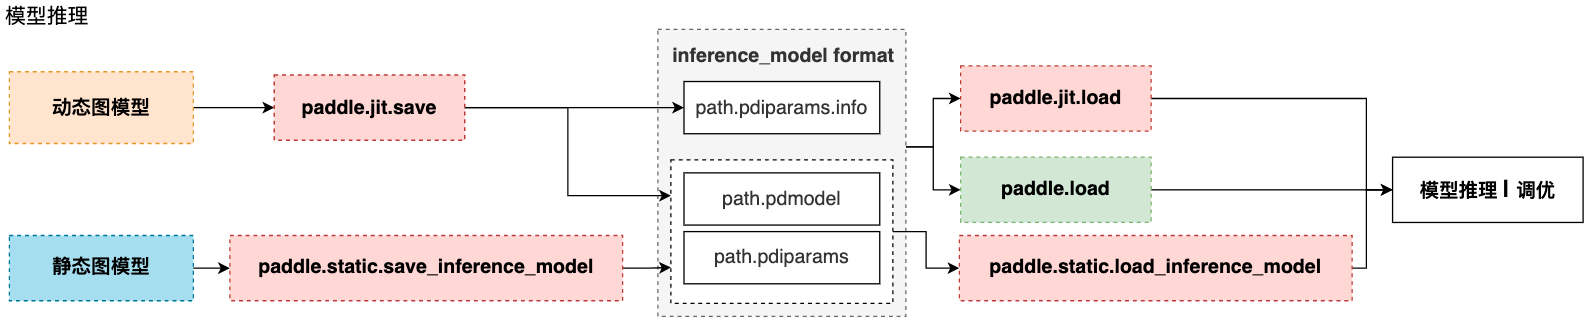

### 训练调优场景的模型&参数保存和载入
#### 动态图参数保存载入
- 若仅需保存和载入模型参数，可以使用`paddle.save/load`结合Layer和Optimizer的state_dict达成目的
- 此处stete_dict是持久参数的载体，dict的key为参数名，value为参数真实的numpy array值

In [2]:
import numpy as np
import paddle
import paddle.nn as nn
import paddle.optimizer as opt

BATCH_SIZE = 16
BATCH_NUM = 4
EPOCH_NUM = 4

IMAGE_SIZE = 784
CLASS_NUM = 10

# 随机定义一个数据集
class RandomDataset(paddle.io.Dataset):
    def __init__(self, num_samples):
        self.num_samples = num_samples

    def __getitem__(self, idx):
        image = np.random.random([IMAGE_SIZE]).astype('float32')
        label = np.random.randint(0, CLASS_NUM - 1, (1, )).astype('int64')
        return image, label

    def __len__(self):
        return self.num_samples

class LinearNet(nn.Layer):
    def __init__(self):
        super(LinearNet, self).__init__()
        self._linear = nn.Linear(IMAGE_SIZE, CLASS_NUM)

    def forward(self, x):
        return self._linear(x)

def train(layer, loader, loss_fn, opt):
    for epoch_id in range(EPOCH_NUM):
        for batch_id, (image, label) in enumerate(loader()):
            out = layer(image)
            loss = loss_fn(out, label)
            loss.backward()
            opt.step()
            opt.clear_grad()
            print("Epoch {} batch {}: loss = {}".format(
                epoch_id, batch_id, np.mean(loss.numpy())))

# 创建网络
layer = LinearNet()
loss_fn = nn.CrossEntropyLoss()
adam = opt.Adam(learning_rate=0.001, parameters=layer.parameters())

# 创建数据加载器
dataset = RandomDataset(BATCH_NUM * BATCH_SIZE)
loader = paddle.io.DataLoader(dataset,
    batch_size=BATCH_SIZE,
    shuffle=True, # 生成mini-batch索引列表时是否对索引打乱顺序
    drop_last=True, # 是否丢弃因数据集样本数不能被 batch_size 整除而产生的最后一个不完整的mini-batch
    num_workers=2) # 用于加载数据的子进程个数

# train
train(layer, loader, loss_fn, adam)

Epoch 0 batch 0: loss = 2.429558277130127
Epoch 0 batch 1: loss = 2.464637279510498
Epoch 0 batch 2: loss = 2.1879477500915527
Epoch 0 batch 3: loss = 2.423316478729248
Epoch 1 batch 0: loss = 2.1715478897094727
Epoch 1 batch 1: loss = 2.3771016597747803
Epoch 1 batch 2: loss = 2.3053817749023438
Epoch 1 batch 3: loss = 2.205760955810547
Epoch 2 batch 0: loss = 2.541815996170044
Epoch 2 batch 1: loss = 2.3652024269104004
Epoch 2 batch 2: loss = 2.513251781463623
Epoch 2 batch 3: loss = 2.3288111686706543
Epoch 3 batch 0: loss = 2.354166269302368
Epoch 3 batch 1: loss = 2.1874775886535645
Epoch 3 batch 2: loss = 2.167081594467163
Epoch 3 batch 3: loss = 2.3685050010681152


D:\anaconda\envs\lc-or\lib\site-packages\paddle\fluid\reader.py:355: UserWarning: DataLoader with multi-process mode is not supported on MacOs and Windows currently. Please use signle-process mode with num_workers = 0 instead
  warnings.warn(


In [8]:
# 参数保存
paddle.save(layer.state_dict(), "linear_net.pdparams")
paddle.save(adam.state_dict(), "adam.pdopt")

# 参数载入
# 先从磁盘中载入保存的state_dict
layer_state_dict = paddle.load("linear_net.pdparams")
opt_state_dict = paddle.load("adam.pdopt")

# 再通过set_state_dict配置到目标对象中
layer.set_state_dict(layer_state_dict)
adam.set_state_dict(opt_state_dict)

layer.summary()

AttributeError: 'LinearNet' object has no attribute 'summary'

####  静态图模型&参数保存载入
- 若仅需要保存/载入模型的参数，可以使用 paddle.save/load 结合Program的state_dict达成目的
- 此处state_dict与动态图state_dict概念类似，dict的key为参数名，value为参数真实的值。
- 若想保存整个模型，需要使用``paddle.save``将Program和state_dict都保存下来。

In [18]:
import paddle
import paddle.static as static

paddle.enable_static()

# create network
x = paddle.static.data(name="x", shape=[None, 224], dtype='float32')
z = paddle.static.nn.fc(x, 10)

place = paddle.CPUPlace()
exe = paddle.static.Executor(place)
exe.run(paddle.static.default_startup_program())
prog = paddle.static.default_main_program()
# paddle.disable_static()

In [19]:
# 保存参数时，先获取Program的state_dict，然后将state_dict保存到磁盘上
paddle.save(prog.state_dict(), "temp/model.pdparams")
# 保存整个模型时
paddle.save(prog, "temp/model.pdmodel")

In [21]:
# 若保存了整个模型时，先载入Program， 没有的话则跳过
prog = paddle.load("temp/model.pdmodel")
# 载入参数时，先从磁盘载入保存的state_dict, 然后通过set_state_dict方法配置到Program中
state_dict = paddle.load("temp/model.pdparams")
prog.set_state_dict(state_dict)
paddle.disable_static()

### 部署场景的模型&参数保存载入
####  动态图模型&参数保存和载入（训练推理）
- 保存/载入动态图模型结构和参数，可以使用 `paddle.jit.save/load` 实现。
- 动态图模型&参数载入
    1. 动转静模型训练 + 模型&参数保存
    2. 动态图模型训练 + 模型&参数保存

In [24]:
# 动转静模型训练 + 模型&参数保存: 直接将目标Layer传入 paddle.jit.save 保存即可
import numpy as np
import paddle
import paddle.nn as nn
import paddle.optimizer as opt

BATCH_SIZE = 16
BATCH_NUM = 4
EPOCH_NUM = 4

IMAGE_SIZE = 784
CLASS_NUM = 10

# define a random dataset
class RandomDataset(paddle.io.Dataset):
    def __init__(self, num_samples):
        self.num_samples = num_samples

    def __getitem__(self, idx):
        image = np.random.random([IMAGE_SIZE]).astype('float32')
        label = np.random.randint(0, CLASS_NUM - 1, (1, )).astype('int64')
        return image, label

    def __len__(self):
        return self.num_samples

class LinearNet(nn.Layer):
    def __init__(self):
        super(LinearNet, self).__init__()
        self._linear = nn.Linear(IMAGE_SIZE, CLASS_NUM)

    @paddle.jit.to_static # Layer对象的forward方法需要经由 paddle.jit.to_static 装饰
    def forward(self, x):
        return self._linear(x)

def train(layer, loader, loss_fn, opt):
    for epoch_id in range(EPOCH_NUM):
        for batch_id, (image, label) in enumerate(loader()):
            out = layer(image)
            loss = loss_fn(out, label)
            loss.backward()
            opt.step()
            opt.clear_grad()
            print("Epoch {} batch {}: loss = {}".format(
                epoch_id, batch_id, np.mean(loss.numpy())))

# create network
layer = LinearNet()
loss_fn = nn.CrossEntropyLoss()
adam = opt.Adam(learning_rate=0.001, parameters=layer.parameters())

# create data loader
dataset = RandomDataset(BATCH_NUM * BATCH_SIZE)
loader = paddle.io.DataLoader(dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=2)

# train
train(layer, loader, loss_fn, adam)

Epoch 0 batch 0: loss = 2.569532871246338
Epoch 0 batch 1: loss = 2.3074564933776855
Epoch 0 batch 2: loss = 2.2230496406555176
Epoch 0 batch 3: loss = 2.37839937210083
Epoch 1 batch 0: loss = 2.33284854888916
Epoch 1 batch 1: loss = 2.1772217750549316
Epoch 1 batch 2: loss = 2.3515210151672363
Epoch 1 batch 3: loss = 2.274106025695801
Epoch 2 batch 0: loss = 2.77471923828125
Epoch 2 batch 1: loss = 2.6141533851623535
Epoch 2 batch 2: loss = 2.72418212890625
Epoch 2 batch 3: loss = 2.616234302520752
Epoch 3 batch 0: loss = 2.399535655975342
Epoch 3 batch 1: loss = 2.7642619609832764
Epoch 3 batch 2: loss = 2.1503686904907227
Epoch 3 batch 3: loss = 2.407644271850586


D:\anaconda\envs\lc-or\lib\site-packages\paddle\fluid\reader.py:355: UserWarning: DataLoader with multi-process mode is not supported on MacOs and Windows currently. Please use signle-process mode with num_workers = 0 instead
  warnings.warn(


In [25]:
# save
path = "example.model/linear"
paddle.jit.save(layer, path)

通过**动转静训练后保存模型&参数**，有以下三项注意点：
1. Layer对象的forward方法需要经由 paddle.jit.to_static 装饰
    - 若最终需要生成的描述模型的Program支持动态输入，可以同时指明模型的 `InputSepc`
        - `@paddle.jit.to_static(input_spec=[InputSpec(shape=[None, 784], dtype='float32')])`
2. 请确保Layer.forward方法中仅实现预测功能，避免将训练所需的loss计算逻辑写入forward方法
    - Layer更准确的语义是描述一个具有预测功能的模型对象，接收输入的样本数据，输出预测的结果，而loss计算是仅属于模型训练中的概念。
3. 如果需要保存多个方法，需要用 paddle.jit.to_static 装饰每一个需要被保存的方法。

In [26]:
# 动态图训练 + 模型&参数保存
import numpy as np
import paddle
import paddle.nn as nn
import paddle.optimizer as opt
from paddle.static import InputSpec

BATCH_SIZE = 16
BATCH_NUM = 4
EPOCH_NUM = 4

IMAGE_SIZE = 784
CLASS_NUM = 10

# define a random dataset
class RandomDataset(paddle.io.Dataset):
    def __init__(self, num_samples):
        self.num_samples = num_samples

    def __getitem__(self, idx):
        image = np.random.random([IMAGE_SIZE]).astype('float32')
        label = np.random.randint(0, CLASS_NUM - 1, (1, )).astype('int64')
        return image, label

    def __len__(self):
        return self.num_samples

class LinearNet(nn.Layer):
    def __init__(self):
        super(LinearNet, self).__init__()
        self._linear = nn.Linear(IMAGE_SIZE, CLASS_NUM)

    def forward(self, x):
        return self._linear(x)

def train(layer, loader, loss_fn, opt):
    for epoch_id in range(EPOCH_NUM):
        for batch_id, (image, label) in enumerate(loader()):
            out = layer(image)
            loss = loss_fn(out, label)
            loss.backward()
            opt.step()
            opt.clear_grad()
            print("Epoch {} batch {}: loss = {}".format(
                epoch_id, batch_id, np.mean(loss.numpy())))

# create network
layer = LinearNet()
loss_fn = nn.CrossEntropyLoss()
adam = opt.Adam(learning_rate=0.001, parameters=layer.parameters())

# create data loader
dataset = RandomDataset(BATCH_NUM * BATCH_SIZE)
loader = paddle.io.DataLoader(dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=2)

# train
train(layer, loader, loss_fn, adam)

Epoch 0 batch 0: loss = 3.140429973602295
Epoch 0 batch 1: loss = 2.4334776401519775
Epoch 0 batch 2: loss = 2.3867716789245605
Epoch 0 batch 3: loss = 2.249695301055908
Epoch 1 batch 0: loss = 2.2894959449768066
Epoch 1 batch 1: loss = 2.4663476943969727
Epoch 1 batch 2: loss = 2.5003628730773926
Epoch 1 batch 3: loss = 2.604400634765625
Epoch 2 batch 0: loss = 2.3025002479553223
Epoch 2 batch 1: loss = 2.6246585845947266
Epoch 2 batch 2: loss = 2.164689064025879
Epoch 2 batch 3: loss = 2.3111414909362793
Epoch 3 batch 0: loss = 2.152470111846924
Epoch 3 batch 1: loss = 2.1835100650787354
Epoch 3 batch 2: loss = 2.29185152053833
Epoch 3 batch 3: loss = 2.2222840785980225


In [27]:
# 训练完成后使用 paddle.jit.save 对模型和参数进行存储
path = "example.dy_model/linear"
paddle.jit.save(
    layer=layer,
    path=path,
    input_spec=[InputSpec(shape=[None, 784], dtype='float32')])

动态图训练后使用 `paddle.jit.save` 保存模型和参数注意点如下
1. 相比动转静训练，Layer对象的forward方法不需要额外装饰
2. 与动转静训练相同，请确保Layer.forward方法中仅实现预测功能，避免将训练所需的loss计算逻辑写入forward方法
3. 在最后使用 `paddle.jit.save` 时，需要指定Layer的 `InputSpec` ，Layer对象forward方法的每一个参数均需要对应的 `InputSpec` 进行描述，不能省略。这里的 `input_spec` 参数支持两种类型的输入：
    - `InputSpec` 列表：描述forward输入参数的shape，dtype和name
        - e.g. `paddle.jit.save(layer=layer, path=path, input_spec=[InputSpec(shape=[None, 784], dtype='float32')])`
    - Example Tensor 列表: 也可以使用forward训练时的示例输入 `image`
        - `paddle.jit.save(layer=layer, path=path, input_spec=[image])`

In [33]:
# 动态图训练 + 模型&参数载入
# 载入模型参数，使用 paddle.jit.load 载入即可
# 如果只需要载入模型的参数，可以使用paddle.load(),返回模型的state_dict
import numpy as np
import paddle
import paddle.nn as nn
import paddle.optimizer as opt

BATCH_SIZE = 16
BATCH_NUM = 4
EPOCH_NUM = 4

IMAGE_SIZE = 784
CLASS_NUM = 10

# load
path = "example.model/linear"
loaded_layer = paddle.jit.load(path)

# 载入模型后进行预测
# inference
loaded_layer.eval()
x = paddle.randn([1, IMAGE_SIZE], 'float32')
pred = loaded_layer(x)

# 载入模型及参数后进行调优
loaded_layer.train()
dataset = RandomDataset(BATCH_NUM * BATCH_SIZE)
loader = paddle.io.DataLoader(dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=2)
loss_fn = nn.CrossEntropyLoss()
adam = opt.Adam(learning_rate=0.001, parameters=loaded_layer.parameters())
train(loaded_layer, loader, loss_fn, adam)
# save after fine-tuning
paddle.jit.save(loaded_layer, "fine-tune.model/linear", input_spec=[x])

Epoch 0 batch 0: loss = 2.443363666534424
Epoch 0 batch 1: loss = 2.372487783432007
Epoch 0 batch 2: loss = 2.280857563018799
Epoch 0 batch 3: loss = 2.2183735370635986
Epoch 1 batch 0: loss = 2.5837316513061523
Epoch 1 batch 1: loss = 2.3033299446105957
Epoch 1 batch 2: loss = 2.510331392288208
Epoch 1 batch 3: loss = 2.144460678100586
Epoch 2 batch 0: loss = 2.412292718887329
Epoch 2 batch 1: loss = 2.203011989593506
Epoch 2 batch 2: loss = 2.4237630367279053
Epoch 2 batch 3: loss = 2.3057126998901367
Epoch 3 batch 0: loss = 2.2217373847961426
Epoch 3 batch 1: loss = 2.3899993896484375
Epoch 3 batch 2: loss = 2.496295690536499
Epoch 3 batch 3: loss = 2.2888622283935547


####  静态图模型&参数保存和载入
保存/载入静态图推理模型，可以通过`paddle.static.save/load_inference_model`实现

In [38]:
import paddle
import numpy as np

paddle.enable_static()
# Build the model
startup_prog = paddle.static.default_startup_program()
main_prog = paddle.static.default_main_program()
with paddle.static.program_guard(main_prog, startup_prog):
    image = paddle.static.data(name="img", shape=[64, 784])
    w = paddle.create_parameter(shape=[784, 200], dtype='float32')
    b = paddle.create_parameter(shape=[200], dtype='float32')
    hidden_w = paddle.matmul(x=image, y=w)
    hidden_b = paddle.add(hidden_w, b)
exe = paddle.static.Executor(paddle.CPUPlace())
exe.run(startup_prog)

[]

静态图导出推理模型需要指定导出路径、输入、输出变量以及执行器
- `save_inference_model`会裁剪Program冗余的部分，并导出两个文件：`path_prefix.pdmodel`, `path_prefix.pdparams`

In [40]:
# Save the inference model
path_prefix = "./infer_model"
paddle.static.save_inference_model(path_prefix, [image], [hidden_b], exe)

载入静态图推理模型时，输入给 `load_inference_model` 的路径必须与 `save_inference_model` 的一致

In [41]:
[inference_program, feed_target_names, fetch_targets] = (
    paddle.static.load_inference_model(path_prefix, exe))
tensor_img = np.array(np.random.random((64, 784)), dtype=np.float32)
results = exe.run(inference_program,
                feed={feed_target_names[0]: tensor_img},
                fetch_list=fetch_targets)